In [1]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Featurizer class definition

class Featurizer():
    
    def __init__(self, fp_len, fp_type):
        self.fp_len = fp_len
        self.fp_type = fp_type
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        
        df = df[df['Ki']<=1e4]
        df = df[df['Ki']>0.01]
        labels = df['Ki']
        
        fp = []
        for index, row in df.iterrows():
            fp = row[1:self.fp_len+1]
            fingerprints.append(fp)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels
        
class KlekFeaturizer(Featurizer):
    def __init__(self, fp_len=4860, fp_type='Klek',):
        super().__init__(fp_len, fp_type)
    
class MACCSFeaturizer(Featurizer):
    def __init__(self, fp_len=166, fp_type='MACCS'):
        super().__init__(fp_len, fp_type)
        
class SubFeaturizer(Featurizer):
    def __init__(self, fp_len=307, fp_type='Sub'):
        super().__init__(fp_len, fp_type)

In [2]:
# Text file to DataFrame object

filename = 'data/d2_SubFP_final_file.csv'
df = pd.read_csv(filename)
df = df.dropna()

featurizer = SubFeaturizer()
fp_train, ki_train = featurizer(df)

fp_train = torch.from_numpy(fp_train)
ki_train = torch.from_numpy(ki_train)

assert fp_train.shape[0] == ki_train.shape[0], 'X_train and y_train rows do not match'

In [3]:
# Data loader

from torch.utils.data import DataLoader, TensorDataset

tensor_ds = TensorDataset(fp_train, ki_train)
train = tensor_ds

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [4]:
# Autoencoder class definition

fp_len = featurizer.fp_len # Klek=4860, MACCS=166, Sub=307
code_len = 8 # latent space size

class Autoencoder(nn.Module):
    
    torch.set_default_dtype(torch.float64)
    
    def __init__(self, fp_len, code_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(fp_len, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, code_len)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(code_len ,16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, fp_len),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def encode(self, x):
        encoded = self.encoder(x)
        return encoded
    
    def decode(self, latent_x):
        decoded = self.decoder(latent_x)
        return decoded

In [5]:
def train(train_dataloader):

    epochs = 50
    
    model = Autoencoder(fp_len, code_len)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(epochs):
        for (fp, _) in train_dataloader:
            encoded, recon = model(fp)
            loss = criterion(recon, fp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
    
    return model
    
# train

model = train(train_dataloader)

# encode

encoded, recon = model(fp_train)
encoded = encoded.detach().numpy()

Epoch: 1, Loss: 0.6883613081884298
Epoch: 2, Loss: 0.6799864768385295
Epoch: 3, Loss: 0.6693606556028185
Epoch: 4, Loss: 0.6533927847926473
Epoch: 5, Loss: 0.6278407481398781
Epoch: 6, Loss: 0.5862334050063156
Epoch: 7, Loss: 0.5224860756274392
Epoch: 8, Loss: 0.4265466046572667
Epoch: 9, Loss: 0.3101597261135237
Epoch: 10, Loss: 0.21658709216888405
Epoch: 11, Loss: 0.14737217609230988
Epoch: 12, Loss: 0.1175922533624044
Epoch: 13, Loss: 0.09812168034256395
Epoch: 14, Loss: 0.08765128882487547
Epoch: 15, Loss: 0.07429492810014636
Epoch: 16, Loss: 0.07517985435246174
Epoch: 17, Loss: 0.06249767707339415
Epoch: 18, Loss: 0.0776253546321946
Epoch: 19, Loss: 0.06419823083067472
Epoch: 20, Loss: 0.066528205755608
Epoch: 21, Loss: 0.07294733156036859
Epoch: 22, Loss: 0.06910598155829663
Epoch: 23, Loss: 0.06000914108343465
Epoch: 24, Loss: 0.06147212689506554
Epoch: 25, Loss: 0.051834794133241296
Epoch: 26, Loss: 0.05893544693392329
Epoch: 27, Loss: 0.06169650784067539
Epoch: 28, Loss: 0.053

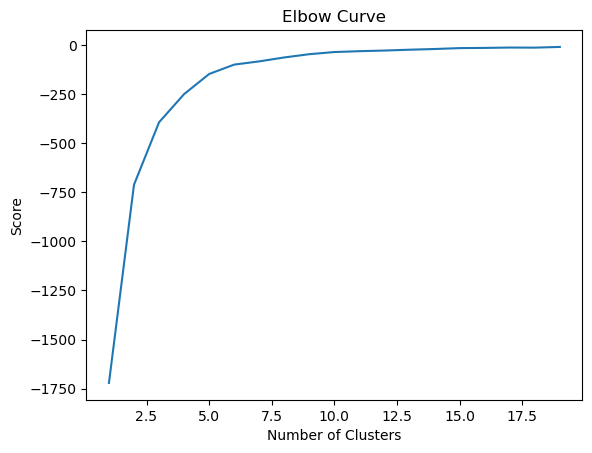

Silhouette score: 0.5727145182609982


In [8]:
from sklearn import cluster
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# Filtering df for active compounds only

activity = (ki_train < 10)
activity = np.array(activity)
encoded_df = pd.DataFrame(encoded)
encoded_df['Activity'] = activity
active_df = encoded_df.loc[encoded_df['Activity'] == True]
active_df = active_df.drop(columns='Activity')

# Choosing optimal number of clusters

Nc = range(1, 20)
kmeans = [cluster.KMeans(n_clusters=i, n_init='auto') for i in Nc]
score = [kmeans[i].fit(active_df).score(active_df) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# Clustering active compounds in 8-dimensional latent space

clu = cluster.KMeans(n_clusters=8, init='k-means++', n_init='auto', max_iter=1000, 
        tol=0.001, random_state=42, copy_x=True, algorithm='lloyd')
clu.fit(active_df)

pred = clu.predict(active_df)
pred = np.array(pred)

score = metrics.silhouette_score(active_df, pred)
print("Silhouette score:", score)

In [10]:
# dataset prepatarion for t-SNE visualization 

active_df['Activity'] = 1
active_df['Cluster'] = pred+1
tsne_df = pd.DataFrame(encoded)
tsne_df['Activity'] = activity
tsne_df['Cluster'] = 0
tsne_df.update(active_df)

tsne_df.head()

,0,1,2,3,4,5,6,7,Activity,Cluster
0,-2.494242,0.687605,8.006783,0.593345,2.739073,4.890792,-1.052454,-5.421341,0.0,0.0
1,-2.677857,0.706915,8.533818,0.651132,2.911272,5.215253,-1.112152,-5.776966,1.0,2.0
2,-2.732580,0.718656,8.687990,0.662280,2.966927,5.313109,-1.124506,-5.882637,0.0,0.0
3,-2.669214,0.710056,8.517919,0.654636,2.900975,5.205438,-1.108557,-5.764774,0.0,0.0
4,-2.535834,0.692512,8.128631,0.608653,2.778501,4.966875,-1.062765,-5.503936,1.0,5.0


...tSNE...


/tmp/ipykernel_12152/1700977997.py:12: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], marker=".",


<Axes: >

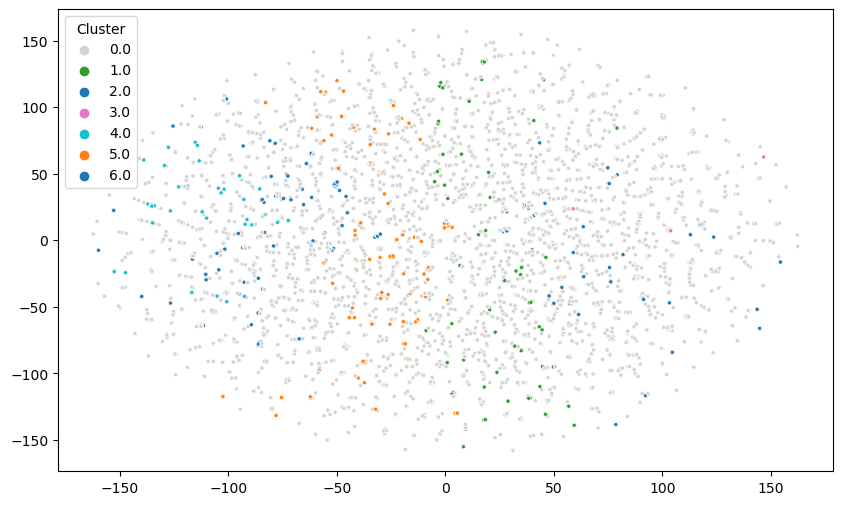

In [11]:
from sklearn.manifold import TSNE
from sklearn import datasets
import seaborn as sns

tsne = TSNE(perplexity=5, learning_rate=200)

print('...tSNE...')
X_tsne = tsne.fit_transform(encoded_df.loc[:, ~encoded_df.columns.isin(['Activity', 'Cluster'])])

colors = ['#D3D3D3', '#2ca02c', '#1f77b4', '#e377c2', '#17becf', '#ff7f0e', '#1f77b4', '#bcbd22', '#9467bd']
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], marker=".", 
                hue=tsne_df['Cluster'], palette=colors,)

In [ ]:
latent_centres = torch.from_numpy(np.array(clu.cluster_centers_))
fp_centres = model.decode(centres)
fp_centres = np.array(decoded_centres > 0.5)